# Chapter 2: The Lucas Tree Model of Asset Pricing
## Jincheng(Eric) Huang

These exercises will give some familiarity with the GMM estimation of asset pricing models.
Assume that the joint distribution of $\left(m_{t+1}, R_{t+1}\right)$ is constant for all $t$ (this would occur, for example, if the stochastic process $\omega$ is Markov). Define $m_{t+1}=\beta \frac{u^{\prime}\left(c_{t+1}\right)}{u^{\prime}\left(c_{t}\right)}$ and $u(c)=\frac{c^{1-\gamma}}{1-\gamma}$. Download data on real personal consumption expenditures (FRED series PCECC96) and returns to the aggregate U.S. stock market (e.g. the Wilshire 5000 given in FRED series WILL5000INDFC) as well as the risk-free rate (FRED series GDPDEF, the GDP deflator, is one possible measure of inflation). One possibility for data on the risk-free rate is the 3-month T-Bill rate given in FRED series TB3MS. Note that you will need to transform the Wilshire 5000 series and the T-Bill series into quarterly data as well as calculate the real returns to the Wilshire 5000 by accounting for inflation.

1. Assume that $\beta=0.99$ (since this is quarterly data, this implies an annual risk free rate of about $4\%$). Calculate the sample analogs of the expected values and covariance in (5). Using `scipy.optimize.broyden1`, solve for the value of $\gamma$ that leads to equation (5) holding.

First, we construct series of stochastic discount factor $m_{t+1}$ and real stock return $R_{t+1}$ using the raw data.

In [1]:
#pip install ipympl

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import broyden1, minimize, fsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Read raw data file downloaded from FRED
data = pd.read_csv('data.csv',na_values='.')
data.head()

,DATE,PCECC96,WILL5000IND,GDPDEF,TB3MS
0,1971-01-01,3156.978,NaN,22.391,3.840000
1,1971-04-01,3185.993,1.136667,22.685,4.250000
2,1971-07-01,3211.394,1.113333,22.916,5.010000
3,1971-10-01,3264.679,1.113333,23.107,4.230000
4,1972-01-01,3307.767,1.240000,23.458,3.436667


In [4]:
# Construct series for real consumption, nominal stock return and GDP deflator and their lags
c_real_series = data['PCECC96']
c_real_series_lag = data['PCECC96'].shift(1)
p_series = data['WILL5000IND']
p_series_lag = data['WILL5000IND'].shift(1)
GDPDEF_series = data['GDPDEF']
GDPDEF_series_lag = data['GDPDEF'].shift(1)

In [5]:
# Define functions to use later
u_prime = lambda c,γ: c**(-γ)
sdf = lambda cs,cs_lag,β,γ1: β*(cs.apply(u_prime,γ=γ1)/cs_lag.apply(u_prime,γ=γ1))

In [6]:
# Adjust the nominal stock returns by inflation to get real returns
R_nominal = p_series/p_series_lag
inflation = GDPDEF_series/GDPDEF_series_lag
R = R_nominal/inflation

In [7]:
# Function where the root equals γ using the moment condition involving market return 
def find_γ_market(γ,β,c_real,c_real_lag,R):
    m = sdf(c_real,c_real_lag,β,γ)
    cov_sample = R.cov(m)
    Em_sample = m.mean(skipna = True) 
    ER_sample = R.mean(skipna = True) 
    return cov_sample + Em_sample*ER_sample - 1

In [8]:
# Solve for γ
β = .99
f1 = lambda γ: find_γ_market(γ,β,c_real_series,c_real_series_lag,R)
γ1 = broyden1(f1,2)
print('γ is: %1.4f' % γ1)

γ is: 1.1580


3. Now, consider the moment restriction given in equation (7). Continue to assume that $\beta = 0.99$. Estimate the $\gamma$ that generates the SDF using only this moment condition. How does this $\gamma$ differ from the estimate of $\gamma$ found previously?

In [9]:
# Construct series for real interest rate
rf_series = data['TB3MS'] / 100

In [10]:
def find_γ_rf(γ,β,c_real,c_real_lag,rf):
    m = sdf(c_real,c_real_lag,β,γ)
    Em_sample = m.mean()
    Erf_sample = rf.mean()
    return 1+Erf_sample - 1/Em_sample

In [11]:
f2 = lambda γ: find_γ_rf(γ,β,c_real_series,c_real_series_lag,rf_series)
γ2 = broyden1(f2,2)
print('γ is: %1.4f' % γ2)

γ is: 4.8145


4. Finally, estimate $\beta$ and $\gamma$ using both equation (5) and equation (7). You will need to specify a weighting matrix (the identity matrix is a great place to start). Plot the objective function for different $(\beta, \gamma)$ pairs. How does your estimation differ from the previous two ways of estimating those parameters?

In [12]:
def moment_conditions(γ,β,c_real,c_real_lag,rf,R):
    m = sdf(c_real,c_real_lag,β,γ).astype('float64')
    cov_sample = R.cov(m)
    Em_sample = m.mean()
    ER_sample = R.mean()
    Erf_sample = rf.mean()
    
    moments = np.zeros((1,2))
    moments[0][0] = cov_sample + Em_sample*ER_sample - 1
    moments[0][1] = Em_sample*(1+Erf_sample) - 1
    return moments

def find_γ_GMM(γ,W,β,c_real,c_real_lag,rf,R):
    moments = moment_conditions(γ,β,c_real,c_real_lag,rf,R)
    
    weighted_moments = moments.dot(W).dot(moments.T)
    return weighted_moments

In [13]:
# First use identity matrix to calculate the first-stage GMM estimator
W = np.identity(2)
f3 = lambda γ: find_γ_GMM(γ,W,β,c_real_series,c_real_series_lag,rf_series,R)
γ3_1 = minimize(f3,2).x

# Use optimal weight matrix to calculate the second-stage GMM estimator
moments = moment_conditions(γ3_1,β,c_real_series,c_real_series_lag,rf_series,R)
W_optimal = np.linalg.inv(1/2*moments.T.dot(moments))
f4 = lambda γ: find_γ_GMM(γ,W_optimal,β,c_real_series,c_real_series_lag,rf_series,R)
γ3_2 = minimize(f4,2).x
print('γ is: %1.4f' % γ3_2)

γ is: 2.9651


<IPython.core.display.Javascript object>


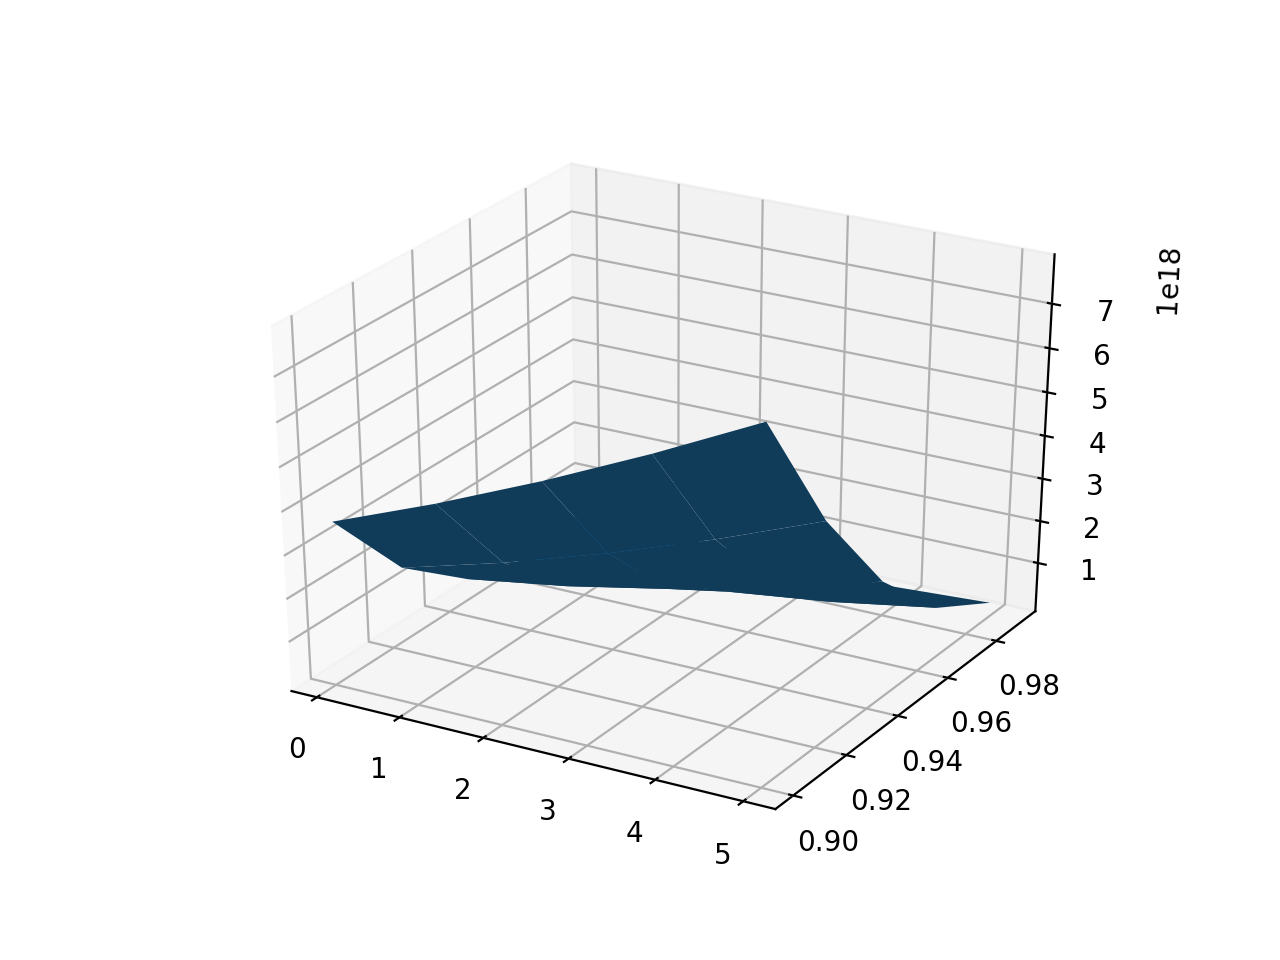

In [14]:
γ_grid = np.linspace(.05,5,5)
β_grid = np.linspace(.9,.99,5)
Grid = np.meshgrid(γ_grid,β_grid)
f4 = np.vectorize(lambda γ,β: find_γ_GMM(γ,W_optimal,β,c_real_series,c_real_series_lag,rf_series,R))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(Grid[0],Grid[1],f4(Grid[0],Grid[1]))